In [1]:
pip install pytorch-model-summary

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchsampler

Note: you may need to restart the kernel to use updated packages.


In [50]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from pytorch_model_summary import summary
from helpers import *

In [51]:
# pip install torchsampler
from torchsampler import ImbalancedDatasetSampler

In [52]:
torch.manual_seed(42)

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [54]:
size = 32
batch_size = 64
transformation = Compose([RandomHorizontalFlip(), Grayscale(), Resize((size, size)), ToTensor()])

In [55]:
def create_dataset(root, transformation):
    dataset = ImageFolder(root, transformation)
    return dataset

In [56]:
def produce_loader(data, sampler=None):
    loader = torch.utils.data.DataLoader(data, batch_size = batch_size, sampler=sampler, shuffle = False)
    return loader

In [57]:
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
sampler_train = ImbalancedDatasetSampler(train_data)
train_loader = produce_loader(train_data, sampler_train)
 

In [58]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data)
len(test_loader.dataset)

585

In [59]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data)
len(val_loader.dataset)

585

In [60]:
def visualize_data(dataset):
    indices = []
    labels_map = {
        0: "Normal",
        1: "Pneumonia",
    }
    cols, rows = 3, 3
    figure = plt.figure(figsize=(8, 8))
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        indices.append(sample_idx)
        img, label = dataset[sample_idx]
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img)
    print(indices)
    indices = []
    plt.show()

[4032, 196, 1080, 1048, 1636, 1156, 3314, 1575, 3557]


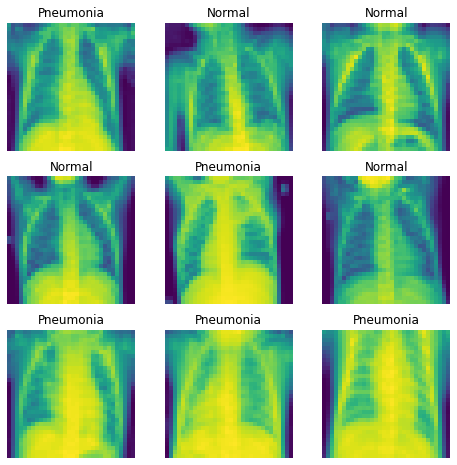

In [61]:
visualize_data(train_data)

[327, 454, 478, 404, 281, 577, 417, 70, 368]


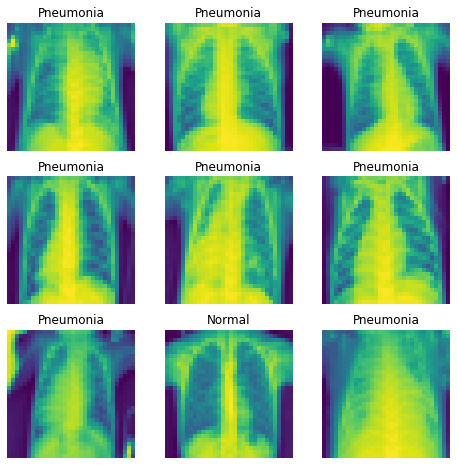

In [62]:
visualize_data(test_data)

In [69]:
resnet = models.resnet34(pretrained=True).to(device)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [70]:
resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)

In [71]:
for param in resnet.parameters():
    param.requiresGrad = False
resnet.conv1.requiresGrad = True

In [72]:
resnet.fc = torch.nn.Sequential(resnet.fc, torch.nn.Linear(1000, 2))
print(resnet)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr = 0.001)
resnet.train()
resnet.to(device)
epochs=20

for epoch in range(epochs):
    for i, (images,labels) in enumerate(train_loader):
        output=resnet(images.to(device))
        loss=criterion(output,labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, \
                                                                      epochs, \
                                                                      i+1, \
                                                                      len(train_loader), \
                                                                      loss.item()))

Epoch [1/20], Step [10/74], Loss: 0.2214
Epoch [1/20], Step [20/74], Loss: 0.2469
Epoch [1/20], Step [30/74], Loss: 0.1384
Epoch [1/20], Step [40/74], Loss: 0.0936
Epoch [1/20], Step [50/74], Loss: 0.1077
Epoch [1/20], Step [60/74], Loss: 0.1040
Epoch [1/20], Step [70/74], Loss: 0.1805
Epoch [2/20], Step [10/74], Loss: 0.3449
Epoch [2/20], Step [20/74], Loss: 0.3127
Epoch [2/20], Step [30/74], Loss: 0.1290
Epoch [2/20], Step [40/74], Loss: 0.0418
Epoch [2/20], Step [50/74], Loss: 0.1033
Epoch [2/20], Step [60/74], Loss: 0.1413
Epoch [2/20], Step [70/74], Loss: 0.1050
Epoch [3/20], Step [10/74], Loss: 0.2746
Epoch [3/20], Step [20/74], Loss: 0.1517
Epoch [3/20], Step [30/74], Loss: 0.2112
Epoch [3/20], Step [40/74], Loss: 0.1230
Epoch [3/20], Step [50/74], Loss: 0.0628
Epoch [3/20], Step [60/74], Loss: 0.0847
Epoch [3/20], Step [70/74], Loss: 0.0843
Epoch [4/20], Step [10/74], Loss: 0.2507
Epoch [4/20], Step [20/74], Loss: 0.1078
Epoch [4/20], Step [30/74], Loss: 0.1251
Epoch [4/20], St

In [ ]:
torch.save({'model_state_dict': resnetl.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict()}, 
           './resnet')



In [73]:
resnet.load_state_dict(torch.load("./resnet")["model_state_dict"])

<All keys matched successfully>

Test loss: 0.2711, Test accuracy: 0.9214
Precision: 0.9223946784922394
Recall: 0.9742388758782201
F1 score: 0.9476082004555809


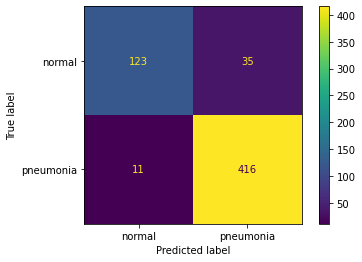

In [75]:
true_labels, model_preds, test_loss, test_accuracy = test(device, resnet.to(device), test_loader, get_predictions=True)
show_metrics(true_labels, model_preds)

In [ ]:
resnet.eval()
total=0
correct=0
with torch.no_grad():
    for images,labels in test_loader:
        output=resnet(images.to(device))
        _,predict=torch.max(output.data,1)
        total+=labels.size(0)
        correct+=(predict == labels.to(device)).sum().item()
print('Test accuracy of the model after retraining for 20 epochs: {} %'.format(100*correct/total))

In [12]:
class DeepSearchConv(torch.nn.Module):
    def __init__(self, inputs, outputs, kernel = 3):
        super(DeepSearchConv, self).__init__()
        
        self.conv = nn.Conv2d(inputs, outputs, kernel_size = kernel)
        self.dropout = nn.Dropout2d(0.5)
        self.batch_norm = nn.BatchNorm2d(outputs)
        
    def forward(self, x):
        x = self.conv(x)
        x = torch.relu(x)
        x = self.batch_norm(x)
        x = self.dropout(x)
        return x

In [13]:
class DeepSearchDownsize(torch.nn.Module):
    def __init__(self, inputs, outputs):
        super(DeepSearchDownsize, self).__init__()
        
        self.maxpool = nn.AvgPool2d(2)
        self.linear = nn.Linear(inputs, outputs)
        self.inputs = inputs
        
    def forward(self, x):
        x = self.maxpool(x)
        x = x.view(-1, self.inputs)
        x = self.linear(x)
        return x

In [14]:
class DeepSearchLinear(torch.nn.Module):
    def __init__(self, inputs, outputs):
        super(DeepSearchLinear, self).__init__()
        
        self.batch_norm = nn.BatchNorm1d(inputs)
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(inputs, outputs)
        
    def forward(self, x):
        x = torch.relu(x)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [15]:
class DeepSearch(torch.nn.Module):
    def __init__(self, hidden, flattened, linear, labels):
        super(DeepSearch, self).__init__()
        
        self.conv = [ DeepSearchConv( hidden[i], hidden[i+1] ) for i in range(len(hidden)-1) ]
        self.conv1 = [ DeepSearchConv( hidden[i+1], hidden[i+1] ) for i in range(len(hidden)-1) ]
        self.downsize = DeepSearchDownsize(flattened, linear)
        self.output = DeepSearchLinear(linear, labels)
        
        self.combined = nn.Sequential(*self.conv,
                                     *self.conv1,
                                      self.downsize,
                                      self.output
                                     )
    
    def forward(self, x):
        x = self.combined(x)
        return x

In [16]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [17]:
def train(model, train_loader, valid_loader, test_loader, optimizer, epochs = 10):
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero out gradients
            optimizer.zero_grad()
            # Compute model output and loss
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            # Backpropagate loss and update model weights
            loss.backward()
            optimizer.step()
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
        
        # Set model to evaluation mode
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in valid_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(valid_loader)
        epoch_acc = correct/total
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Val loss: {epoch_loss:.4f}, Val accuracy: {epoch_acc:.4f}')
    
    model.eval()
    # Initialize epoch loss and accuracy
    epoch_loss = 0.0
    correct = 0
    total = 0
    # Iterate over test data
    for inputs, labels in test_loader:
        # Get from dataloader and send to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Compute model output and loss
        # (No grad computation here, as it is the test data)
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
        # Accumulate loss and correct predictions for epoch
        epoch_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
    epoch_loss /= len(test_loader)
    epoch_acc = correct/total
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_acc)
    print(f'Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
    return train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies

In [18]:
def create_adam_optimizer(lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr=lr, betas=betas)

In [19]:
from math import floor
hidden = [1, 32]
channels = hidden[-1]
changed_img = floor((size-2*(len(hidden)-1))/2)  
linear = 256
labels = 2
flattened = 123008
print(changed_img)

63


In [20]:
model = DeepSearch(hidden=hidden, flattened=flattened, linear=linear, labels=labels).to(device)
optimizer = create_adam_optimizer()
summary(model, torch.zeros((1, 1, 128, 128)).to(device), show_input=False)

'------------------------------------------------------------------------------\n           Layer (type)          Output Shape         Param #     Tr. Param #\n==============================================================================\n       DeepSearchConv-1     [1, 32, 126, 126]             384             384\n       DeepSearchConv-2     [1, 32, 124, 124]           9,312           9,312\n   DeepSearchDownsize-3              [1, 256]      31,490,304      31,490,304\n     DeepSearchLinear-4                [1, 2]           1,026           1,026\n==============================================================================\nTotal params: 31,501,026\nTrainable params: 31,501,026\nNon-trainable params: 0\n------------------------------------------------------------------------------'

In [21]:
model

DeepSearch(
  (downsize): DeepSearchDownsize(
    (maxpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (linear): Linear(in_features=123008, out_features=256, bias=True)
  )
  (output): DeepSearchLinear(
    (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear): Linear(in_features=256, out_features=2, bias=True)
  )
  (combined): Sequential(
    (0): DeepSearchConv(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (dropout): Dropout2d(p=0.5, inplace=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DeepSearchConv(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (dropout): Dropout2d(p=0.5, inplace=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): DeepSearchDownsize(
      (maxpool): AvgPool2d(kernel_

In [23]:
%time
train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies = train(model, \
                                                                                             train_loader, \
                                                                                             val_loader, \
                                                                                             test_loader, \
                                                                                             epochs = 2, \
                                                                                             optimizer = optimizer)

Wall time: 0 ns
Epoch 1/2, Batch number: 0, Cumulated accuracy: 0.46875
Epoch 1/2, Batch number: 1, Cumulated accuracy: 0.453125
Epoch 1/2, Batch number: 2, Cumulated accuracy: 0.4635416666666667
Epoch 1/2, Batch number: 3, Cumulated accuracy: 0.48828125
Epoch 1/2, Batch number: 4, Cumulated accuracy: 0.50625
Epoch 1/2, Batch number: 5, Cumulated accuracy: 0.5052083333333334
Epoch 1/2, Batch number: 6, Cumulated accuracy: 0.5
Epoch 1/2, Batch number: 7, Cumulated accuracy: 0.48828125
Epoch 1/2, Batch number: 8, Cumulated accuracy: 0.4947916666666667
Epoch 1/2, Batch number: 9, Cumulated accuracy: 0.503125
Epoch 1/2, Batch number: 10, Cumulated accuracy: 0.5056818181818182
Epoch 1/2, Batch number: 11, Cumulated accuracy: 0.515625
Epoch 1/2, Batch number: 12, Cumulated accuracy: 0.5264423076923077
Epoch 1/2, Batch number: 13, Cumulated accuracy: 0.5279017857142857
Epoch 1/2, Batch number: 14, Cumulated accuracy: 0.5364583333333334
Epoch 1/2, Batch number: 15, Cumulated accuracy: 0.539062

Epoch 2/2, Batch number: 50, Cumulated accuracy: 0.8232230392156863
Epoch 2/2, Batch number: 51, Cumulated accuracy: 0.8254206730769231
Epoch 2/2, Batch number: 52, Cumulated accuracy: 0.8266509433962265
Epoch 2/2, Batch number: 53, Cumulated accuracy: 0.8263888888888888
Epoch 2/2, Batch number: 54, Cumulated accuracy: 0.8264204545454545
Epoch 2/2, Batch number: 55, Cumulated accuracy: 0.8258928571428571
Epoch 2/2, Batch number: 56, Cumulated accuracy: 0.8264802631578947
Epoch 2/2, Batch number: 57, Cumulated accuracy: 0.8265086206896551
Epoch 2/2, Batch number: 58, Cumulated accuracy: 0.8270656779661016
Epoch 2/2, Batch number: 59, Cumulated accuracy: 0.8278645833333333
Epoch 2/2, Batch number: 60, Cumulated accuracy: 0.8288934426229508
Epoch 2/2, Batch number: 61, Cumulated accuracy: 0.8296370967741935
Epoch 2/2, Batch number: 62, Cumulated accuracy: 0.8293650793650794
Epoch 2/2, Batch number: 63, Cumulated accuracy: 0.82958984375
Epoch 2/2, Batch number: 64, Cumulated accuracy: 0.82

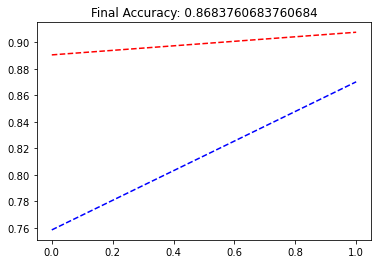

In [49]:
plt.plot(train_accuracies, "b--")
plt.plot(val_accuracies, "r--")
plt.title("Final Accuracy: {}".format(test_accuracies[-1]))
plt.show()

In [52]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './wow')

In [53]:
entire_dataset = torch.utils.data.ConcatDataset([ train_data, test_data, val_data ])
full_loader = produce_loader(entire_dataset)

In [54]:
def test(model, data_loader):
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    test_losses = []
    test_accuracies = []
    model.eval()
    # Initialize epoch loss and accuracy
    epoch_loss = 0.0
    correct = 0
    total = 0
    # Iterate over test data
    for inputs, labels in data_loader:
        # Get from dataloader and send to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Compute model output and loss
        # (No grad computation here, as it is the test data)
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
        # Accumulate loss and correct predictions for epoch
        epoch_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
    epoch_loss /= len(data_loader)
    epoch_acc = correct/total
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_acc)
    print(f'Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
    return test_losses, test_accuracies

In [55]:
full_test_losses, full_test_accuracies = test(model, test_loader)

Test loss: 0.3111, Test accuracy: 0.8872
